In [1]:
import numpy as np
import matplotlib.pyplot as plt

from jax import jit, vmap, config
from jax.lax import cond
import jax.numpy as jnp
import jax.random as jr
import jax.scipy as js
import jax.scipy.linalg as jsl

import numpyro
import numpyro.distributions as dist
from numpyro.infer.initialization import init_to_value

import sys
import os
sys.path.append(os.path.abspath('..'))

from PTA import PTA
from samples import Samples
import constants as c

from ent_data_simulation import params_injected

import pandas as pd
from chainconsumer import ChainConsumer, Chain, Truth, PlotConfig

from ent_data_simulation.pulsar_phase import get_psr_phase

from emcee.autocorr import integrated_time
from time import perf_counter

import healpy as hp

# use double precision
config.update('jax_enable_x64', True)

%load_ext autoreload
%autoreload 2

In [2]:
# load Enterprise pulsar data
data_dict = np.load('ent_data_simulation/data/data_dict.npz', allow_pickle=True)
toas = jnp.array(data_dict['toas'])
residuals = jnp.array(data_dict['residuals'])
Tspans = toas[:, -1] - toas[:, 0]
Tspan = jnp.mean(Tspans)
Tspan_yr = Tspan / c.year_sec
Np = toas.shape[0]
Ntoas = toas.shape[1]
psr_pos = jnp.array(data_dict['psr_pos'])
psr_dists = jnp.array(data_dict['psr_dists'])
psr_dists_inj = psr_dists[0]
psr_dists_stdev = psr_dists[1]
Fs = jnp.array(data_dict['Fs'])
Ms = jnp.array(data_dict['Ms'])
Rs = jnp.array([jnp.eye(Ntoas) - M @ jnp.linalg.inv(M.T @ M) @ M.T
                for M in Ms])
U_s = jnp.array([jnp.linalg.svd(M)[0]
                 for M in Ms])
Gs = jnp.array([U[:, 8:] for U in U_s])
Ns = jnp.array(data_dict['Ns'])
Ntinvs = jnp.array([G @ jnp.linalg.inv(G.T @ N @ G) @ G.T
                    for G, N in zip(Gs, Ns)])
psr_names = data_dict['psr_names']
x_inj_dict = data_dict['x_inj'].item()

Np = toas.shape[0]
Ntoas = toas.shape[1]
Nf = params_injected.num_modes
Na = 2 * Nf

Vs = jnp.array([F.T @ Ntinv @ res for F, Ntinv, res in zip(Fs, Ntinvs, residuals)])
Ws = jnp.array([F.T @ Ntinv @ F for F, Ntinv in zip(Fs, Ntinvs)])

In [3]:
pta = PTA(Np=Np,
          Tspan_yr=15,
          Nf=params_injected.num_modes,
          model_wn=False,
          model_rn=params_injected.rn_model,
          model_gwb=params_injected.gwb_model,
          model_cw=params_injected.cw_model,
          Enterprise_bounds=True,
          Nf_cw=15,
          tref=params_injected.tref)

In [4]:
if Fs.shape == (Np, Ntoas, 0):
    freqs = jnp.arange(1, Nf + 1) / Tspan
    Fs = jnp.zeros((Np, Ntoas, Na))
    for i in range(Np):
        for j in range(Nf):
            Fs = Fs.at[i, :, 2 * j].set(jnp.sin(2. * jnp.pi * \
                                                            freqs[j] * toas[i]))
            Fs = Fs.at[i, :, 2 * j + 1].set(jnp.cos(2. * jnp.pi * \
                                                                freqs[j] * toas[i]))

In [5]:
# angles between pulsars
angles = np.zeros((Np, Np))
for i in range(Np):
    for j in range(i, Np):
        pos1 = psr_pos[i]
        pos2 = psr_pos[j]
        angles[i,j] = angles[j,i] = np.arccos(np.clip(np.dot(pos1, pos2), -1.0, 1.0))
angles = jnp.array(angles)

# Hellings-Downs weighting
alpha = np.zeros((Np, Np))
for i in range(Np):
    for j in range(Np):
        if i == j:
            alpha[i,j] = 1.
        else:
            ang = angles[i,j]
            beta = (1. - np.cos(ang)) / 2.
            alpha[i,j] = 1.5 * beta * np.log(beta) - 0.25 * beta + 0.5
alpha = jnp.array(alpha)
alpha_inv = jnp.linalg.inv(alpha)

In [6]:
N_cw = 8
N_psr = 2 * Np
N_cw_psr = N_cw + N_psr
window_ext_yr = pta.window_ext_yr
Nf_cw = pta.Nf_cw
Na_cw = pta.Na_cw
from scipy.signal.windows import tukey


# window extension for CW FFT (avoids Gibbs phenomena)
window_ext_yr = window_ext_yr
window_ext = window_ext_yr * c.year_sec

# extended Tspan for CW FFT
Tspan_ext_yr = Tspan_yr + 2. * window_ext_yr
Tspan_ext = Tspan_ext_yr * c.year_sec

# sparse TOAs for CW FFT
sparse_toas_CW = jnp.array([jnp.linspace(toas[idx][0] - window_ext,
                                                toas[idx][-1] + window_ext,
                                                Na_cw + 2, endpoint=False)
                                    for idx in range(Np)])  # (Np, N_sparse)
Nsparse = sparse_toas_CW.shape[1]
freqs_forFFT = jnp.array([jnp.fft.fftfreq(Nsparse, Tspan_ext / Nsparse)
                                for _ in range(Np)])

# Fourier design matrix for CW
Fs_cw = jnp.zeros((Np, Ntoas, Na_cw))
for i in range(Np):
    for j in range(Nf_cw):
        Fs_cw = Fs_cw.at[i, :, 2 * j].set(jnp.sin(2. * jnp.pi * \
                                                    freqs_forFFT[i, j + 1] * toas[i]))
        Fs_cw = Fs_cw.at[i, :, 2 * j + 1].set(jnp.cos(2. * jnp.pi * \
                                                        freqs_forFFT[i, j + 1] * toas[i]))            

# Tukey window for FFT
Tukey_cw = tukey(Nsparse, alpha=window_ext_yr/Tspan_ext_yr)
Tukey_cw = jnp.array(Tukey_cw)

In [7]:
# antenna pattern for continuous waves
@jit
def create_gw_antenna_pattern(gwtheta, gwphi):
    '''
    Creates a continuous gravitational wave antenna pattern.

    param: gwtheta: theta coordinate for sky location of CW source
    param: gwphi: phi coordinate for sky location of CW source
    '''

    # use definition from Sesana et al 2010 and Ellis et al 2012
    sgwphi = jnp.sin(gwphi)
    cgwphi = jnp.cos(gwphi)
    sgwtheta = jnp.sin(gwtheta)
    cgwtheta = jnp.cos(gwtheta)

    mdotpos = sgwphi * psr_pos[:, 0] - cgwphi * psr_pos[:, 1]
    ndotpos = -cgwtheta * cgwphi * psr_pos[:, 0] - cgwtheta * sgwphi * psr_pos[:, 1] \
                + sgwtheta * psr_pos[:, 2]
    omhatdotpos = -sgwtheta * cgwphi * psr_pos[:, 0] - sgwtheta * sgwphi * psr_pos[:, 1] \
                    -cgwtheta * psr_pos[:, 2]

    fplus = 0.5 * (mdotpos ** 2 - ndotpos ** 2) / (1 + omhatdotpos)
    fcross = (mdotpos * ndotpos) / (1 + omhatdotpos)
    cosMu = -omhatdotpos

    return fplus, fcross, cosMu

In [8]:
# get signal due to continuous wave
def cw_delay(x_CW):
        # 
        #           psrTerm=True, p_dist=p_dist, p_phase=p_phase,
        #           phase_approx=True, check=False,
        #           tref=tref):


    # unpack parameters
    log10_mc, log10_fgw, cos_inc, psi, log10_dist, cos_gwtheta, gwphi, phase0 = x_CW[:N_cw]
    p_phases = x_CW[N_cw : N_cw + Np]
    pdists = x_CW[N_cw + Np:]

    # convert units to time
    mc = 10 ** log10_mc * c.Tsun
    fgw = 10 ** log10_fgw
    gwtheta = jnp.arccos(cos_gwtheta)
    inc = jnp.arccos(cos_inc)
    p_dists = pdists * c.kpc / c.c
    dist = 10 ** log10_dist * c.Mpc / c.c

    # get antenna pattern funcs and cosMu
    # write function to get pos from theta,phi
    fplus, fcross, cosMu = create_gw_antenna_pattern(gwtheta, gwphi)

    # get pulsar time
    toas_copy = sparse_toas_CW - params_injected.tref
    tp = toas_copy - (p_dists * (1 - cosMu))[:, None]

    # orbital frequency
    w0 = jnp.pi * fgw
    phase0 /= 2  # convert GW to orbital phase
    # omegadot = 96/5 * mc**(5/3) * w0**(11/3) # Not currently used in code

    # monochromatic
    omega = w0
    omega_p = w0 * (1 + 256/5
                    * mc**(5/3) * w0**(8/3) * p_dists*(1-cosMu))**(-3/8)

    # phases
    phase = phase0 + omega * toas_copy
    phase_p = phase0 + p_phases[:, None] + omega_p[:, None] * toas_copy


    # define time dependent coefficients
    At = -0.5*jnp.sin(2*phase)*(3+jnp.cos(2*inc))
    Bt = 2*jnp.cos(2*phase)*jnp.cos(inc)
    At_p = -0.5*jnp.sin(2*phase_p)*(3+jnp.cos(2*inc))
    Bt_p = 2*jnp.cos(2*phase_p)*jnp.cos(inc)

    # now define time dependent amplitudes
    alpha = mc**(5./3.)/(dist*omega**(1./3.))
    alpha_p = mc**(5./3.)/(dist*omega_p**(1./3.))[:, None]

    # define rplus and rcross
    rplus = alpha*(-At*jnp.cos(2*psi)+Bt*jnp.sin(2*psi))
    rcross = alpha*(At*jnp.sin(2*psi)+Bt*jnp.cos(2*psi))
    rplus_p = alpha_p*(-At_p*jnp.cos(2*psi)+Bt_p*jnp.sin(2*psi))
    rcross_p = alpha_p*(At_p*jnp.sin(2*psi)+Bt_p*jnp.cos(2*psi))

    # residuals
    res = fplus[:, None]*(rplus_p-rplus)+fcross[:, None]*(rcross_p-rcross)
    
    return res

# get Fourier coefficients for CW signal in all pulsars
@jit
def get_CW_coefficients(x_CW):
    '''
    Use FFT to get Fourier coefficients for CW residuals given CW parameters.

    params: x_CW: continuous wave parameters
    '''
    cw_residuals = cw_delay(x_CW)
    # window residuals over window
    cw_residuals_windowed = Tukey_cw * cw_residuals
    # cw_residuals_windowed = cw_residuals
    # do FFT
    cw_fft = jnp.fft.fft(cw_residuals_windowed, n=None, axis=-1, norm=None)  # dim (Np, 2 * Nf + 2)
    # apply time shift to fft to set initial time
    cw_fft *= jnp.exp(-1.j * 2 * jnp.pi * freqs_forFFT * sparse_toas_CW[:, 0:1])
    
    # extract sine and cosine coefficients
    a_n = jnp.imag(cw_fft[:, :Nsparse // 2]) * (-2 / Nsparse)  # (Np, Nf + 1)
    b_n = jnp.real(cw_fft[:, :Nsparse // 2]) * (2 / Nsparse)  # (Np, Nf + 1)
    coeff = jnp.concatenate((a_n, b_n), axis=1).reshape((Np, 2, Nf_cw + 1))\
                            .transpose((0, 2, 1)).reshape((Np, Na_cw + 2))
    return coeff[:, 2:]  # remove DC

In [9]:
rho_scale = (c.year_sec ** 3.) / (12. * (jnp.pi ** 2.) * Tspan)
rho_scale1 = Tspan / c.year_sec
arr = jnp.repeat(jnp.arange(1, Nf + 1), 2)
arr /= rho_scale1
arr = jnp.array(arr)


@jit
def get_rho_diag(hyper_params):
    logAmp, gamma = hyper_params
    Amp = 10. ** logAmp
    return (Amp ** 2.) * rho_scale * (arr **  (-gamma))

In [10]:
@jit
def transform_a(gwb_hypers, a_standard_flat):
    rho_diag_inj = get_rho_diag(gwb_hypers)
    phi = rho_diag_inj[:, None, None] * alpha[None, :, :]
    L_phi = jnp.linalg.cholesky(phi)
    a_standard = a_standard_flat.reshape((Na, Np))
    a_stacked = jnp.einsum('fij, fj->fi', L_phi, a_standard)
    return a_stacked.T.flatten()

@jit
def inv_transform_a(gwb_hypers, a_flat):
    rho_diag_inj = get_rho_diag(gwb_hypers)
    phi = rho_diag_inj[:, None, None] * alpha[None, :, :]
    L_inv_phi = jnp.linalg.inv(jnp.linalg.cholesky(phi))
    a = a_flat.reshape((Na, Np))
    a_stacked = jnp.einsum('fij, fj->fi', L_inv_phi, a)
    return a_stacked.T.flatten()

In [11]:
# injected / MAP parameters
psr_phases_inj = jnp.array([get_psr_phase(params_injected.CW_params_inj, pos, distance)
                        for pos, distance in zip(psr_pos, psr_dists_inj)])
x_cw_psr_inj = jnp.concatenate((params_injected.CW_params_inj, psr_phases_inj, jnp.array(psr_dists_inj)))
a_cw_inj = get_CW_coefficients(x_cw_psr_inj)
cw_inj = jnp.array([R @ F @ a for R, F, a in zip(Rs, Fs_cw, get_CW_coefficients(x_cw_psr_inj))])
W_tildes = jnp.array([F.T @ Ntinv @ F_cw for F, Ntinv, F_cw in zip(Fs, Ntinvs, Fs_cw)])
a_MAP = jnp.array([jnp.linalg.inv(W + jnp.diag(1. / get_rho_diag(params_injected.GWB_hypers_inj))) @ (V -  W_tilde @ a_cw)
                   for W, V, W_tilde, a_cw in zip(Ws, Vs, W_tildes, a_cw_inj)])
init_dict = {'gwb_hypers':jnp.array(params_injected.GWB_hypers_inj),
             'a_standard':inv_transform_a(params_injected.GWB_hypers_inj, a_MAP.flatten()),
             'cw': jnp.array(params_injected.CW_params_inj),
             'psr_phases': psr_phases_inj,
             'psr_dists_standard': jnp.zeros(Np),
            }
x_inj_arr = jnp.concatenate((init_dict['gwb_hypers'], x_cw_psr_inj, a_MAP.flatten()))

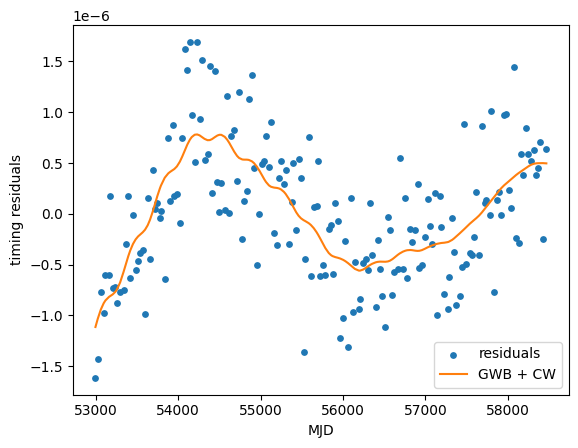

In [12]:
psr_ndx = 4
plt.scatter(toas[psr_ndx] / 86400., residuals[psr_ndx], color='C0', label='residuals', s=15)
plt.plot(toas[psr_ndx] / 86400., Rs[psr_ndx] @ Fs[psr_ndx] @ a_MAP[psr_ndx] + cw_inj[psr_ndx],
         color='C1', label='GWB + CW')
plt.legend()
plt.xlabel('MJD')
plt.ylabel('timing residuals')
plt.show()

In [13]:
efacs = jnp.ones(Np)

Us = jnp.array([res.T @ Ntinv @ res for res, Ntinv in zip(residuals,
                                                                Ntinvs)])
Vs = jnp.array([F.T @ Ntinv @ res for F, Ntinv, res in zip(Fs,
                                                                Ntinvs,
                                                                residuals)])
Ws = jnp.array([F.T @ Ntinv @ F for F, Ntinv in zip(Fs,
                                                            Ntinvs)])
Vs_cw = jnp.array([F.T @ Ntinv @ res for F, Ntinv, res in zip(Fs_cw,
                                                                Ntinvs,
                                                                residuals)])
Ws_cw = jnp.array([F.T @ Ntinv @ F for F, Ntinv in zip(Fs_cw,
                                                            Ntinvs)])
Ws_tilde = jnp.array([F.T @ Ntinv @ F_cw for F, Ntinv, F_cw in zip(Fs,
                                                            Ntinvs, Fs_cw)])

@jit
def lnlike_per_psr_cwbasis(efac, a_rn_gwb, a_cw, U, V, W, V_cw, W_cw, W_tilde):
    lnlike_val = U + a_rn_gwb.T @ W @ a_rn_gwb - 2 * jnp.inner(a_rn_gwb, V)
    lnlike_val += -2. * jnp.inner(a_cw, V_cw) + 2. * a_rn_gwb.T @ W_tilde @ a_cw + a_cw.T @ W_cw @ a_cw
    lnlike_val *= -0.5 / efac**2.
    lnlike_val +=  -(Ntoas) * jnp.log(efac)
    return lnlike_val

vectorized_lnlike_per_psr_cwbasis = jit(vmap(lnlike_per_psr_cwbasis, in_axes=(0, 0, 0, 0, 0, 0, 0, 0, 0)))

# likelihood for all pulsars when CW uses different basis
@jit
def lnlike_cwbasis(efacs, a_rn_gwb, a_cw):
    a_rn_gwb_stacked = a_rn_gwb.reshape((Np, Na))
    a_cw_stacked = a_cw.reshape((Np, Na_cw))
    return jnp.sum(vectorized_lnlike_per_psr_cwbasis(efacs,
                                                    a_rn_gwb_stacked,
                                                    a_cw_stacked,
                                                    Us,
                                                    Vs,
                                                    Ws,
                                                    Vs_cw,
                                                    Ws_cw,
                                                    Ws_tilde))

In [14]:
# prior on Fourier coefficients
def a_lnprior_gwb(gwb_hypers, a):
        # reshape parameters
        a_stacked = a.reshape((Np, Na))

        # covariance matrix for Fourier coefficients
        phi = get_rho_diag(gwb_hypers)[:, None, None] * alpha[None, :, :]

        # prior contribution
        phi_chol_factors = vmap(lambda x: js.linalg.cho_factor(x, lower=True))(phi)
        phiinvs = vmap(lambda cf: js.linalg.cho_solve((cf[0], True),
                                                    jnp.identity(cf[0].shape[0])))(phi_chol_factors)
        philogdets = 2 * jnp.sum(jnp.log(jnp.diagonal(phi_chol_factors[0], axis1=1, axis2=2)), axis=1)
        ln_prior_val = -0.5 * jnp.sum(vmap(lambda x, y: jnp.dot(x, jnp.dot(y, x)))(a_stacked.T, phiinvs))
        ln_prior_val += -0.5 * jnp.sum(philogdets)
        return ln_prior_val

In [15]:
# likelihood density
@jit
def lnlike(x):

    # unpack parameters
    gwb_hypers = x[pta.gwb_ndxs]
    cw_psr_params = x[pta.cw_psr_ndxs]
    psr_dists = x[pta.psr_dist_ndxs]
    a = x[pta.a_ndxs]

    # prior on Fourier coefficients
    # lnprior_val = a_lnprior_gwb(gwb_hypers, a)

    # prior on pulsar distances
    # lnprior_val += jnp.sum(js.stats.norm.logpdf(psr_dists, psr_dists_inj, psr_dists_stdev))

    # likelihood
    a_cw = pta.get_CW_coefficients(cw_psr_params).flatten()
    lnlike_val = lnlike_cwbasis(pta.efacs_inj, a, a_cw)

    return lnlike_val

vectorized_lnlike = jit(vmap(lnlike))

# posterior density
@jit
def lnpost(x):

    # unpack parameters
    gwb_hypers = x[pta.gwb_ndxs]
    cw_psr_params = x[pta.cw_psr_ndxs]
    psr_dists = x[pta.psr_dist_ndxs]
    a = x[pta.a_ndxs]

    # prior on Fourier coefficients
    lnprior_val = a_lnprior_gwb(gwb_hypers, a)

    # prior on pulsar distances
    lnprior_val += jnp.sum(js.stats.norm.logpdf(psr_dists, psr_dists_inj, psr_dists_stdev))

    # likelihood
    a_cw = pta.get_CW_coefficients(cw_psr_params).flatten()
    lnlike_val = lnlike_cwbasis(pta.efacs_inj, a, a_cw)

    return lnprior_val + lnlike_val

vectorized_lnpost = jit(vmap(lnpost))

In [16]:
# efacs = jnp.ones(Np)

def sampling_model():
    
    # RN hyper-parameter have uniform prior
    gwb_hypers = numpyro.sample('gwb_hypers', dist.Uniform(pta.gwb_mins, pta.gwb_maxs))
    
    # draw Fourier coefficients from Gaussian prior
    a_standard = numpyro.sample('a_standard', dist.Normal().expand((pta.Na_PTA,)))
    a = transform_a(gwb_hypers, a_standard)
    numpyro.deterministic('a', a)

    # uniform prior on CW parameters and pulsar phase
    cw = numpyro.sample('cw', dist.Uniform(pta.x_mins[pta.cw_ndxs],
                                           pta.x_maxs[pta.cw_ndxs]))
    psr_phases = numpyro.sample('psr_phases', dist.Uniform(pta.x_mins[pta.psr_phase_ndxs],
                                                           pta.x_maxs[pta.psr_phase_ndxs]))
    
    # normal prior on pulsar distances
    psr_dists_standard = numpyro.sample('psr_dists_standard', dist.Normal().expand((Np,)))
    psr_dists = psr_dists_inj + psr_dists_standard * psr_dists_stdev
    numpyro.deterministic('psr_dists', psr_dists)

    # get Fourier representation of CW
    a_cw = get_CW_coefficients(jnp.concatenate((cw, psr_phases, psr_dists)))

    # likelihood
    numpyro.factor('ln_likelihood', lnlike_cwbasis(efacs, a, a_cw))

In [ ]:
nuts_kernel = numpyro.infer.NUTS(sampling_model,
                                 dense_mass=True,
                                 # dense_mass=[('gwb_hypers', 'a_standard',), ('cw',)],
                                 init_strategy=init_to_value(values=init_dict),
                                 max_tree_depth=10,
                                 # find_heuristic_step_size=True,
                                 )
mcmc = numpyro.infer.MCMC(sampler=nuts_kernel,
                          num_warmup=int(5e3),
                          num_samples=int(6e5))
time_start = perf_counter()
mcmc.run(jr.key(143))
time_stop = perf_counter()

In [ ]:
# convert dictionary of samples into array
samples_dict = mcmc.get_samples()
samples = np.concatenate((samples_dict['gwb_hypers'],
                          samples_dict['cw'],
                          samples_dict['psr_phases'],
                          samples_dict['psr_dists'],
                          samples_dict['a']),
                          axis=1)

In [19]:
hmc_samples = Samples(samples_arr=samples,
                      labels=pta.x_labels,
                      x_inj=x_inj_arr,
                      lnpost_func=lnpost,
                      jax=True)

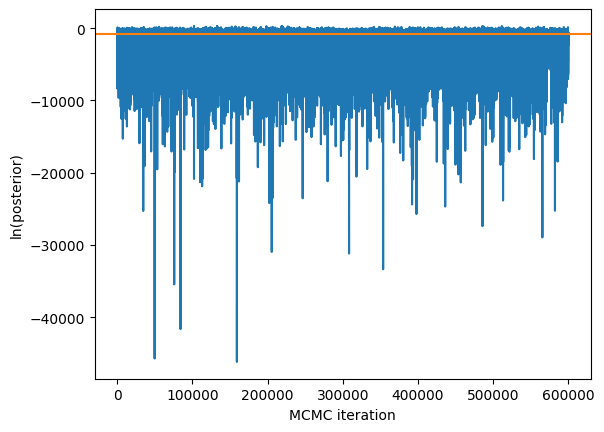

In [20]:
hmc_samples.plt_posterior_vals()

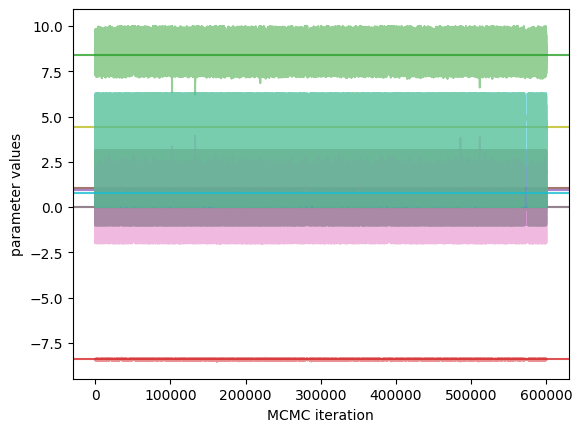

In [21]:
hmc_samples.trace_plt(param_ndxs=pta.cw_ndxs)

In [163]:
burnin = 0
thinned_samples = hmc_samples.samples[burnin::3]
int_times = integrated_time(thinned_samples, has_walkers=False)
max_int_time = np.max(int_times)
effective_sample_size = np.round(thinned_samples.shape[0] / max_int_time)
duration = time_stop - time_start
effective_samples_per_sec = effective_sample_size / duration
print(f'effective samples per second = {effective_samples_per_sec}')

effective samples per second = 0.09089532779745337


In [22]:
# load samples from Enterprise run
ent_df = pd.read_pickle("ent_df.pkl.gz", compression="gzip")

Parameter $\cos{\iota}$ in chain sample Fourier coefficients + 
  compressed CW representation is not constrained
Parameter $\psi$ in chain ENTERPRISE is not constrained
Parameter $\psi$ in chain sample Fourier coefficients + 
  compressed CW representation is not constrained
Parameter $\log_{10}(D_{L}\,\,[\text{Mpc}])$ in chain sample Fourier coefficients + 
  compressed CW representation is not constrained
Parameter $\cos{\theta}$ in chain ENTERPRISE is not constrained
Parameter $\Phi_0$ in chain sample Fourier coefficients + 
  compressed CW representation is not constrained


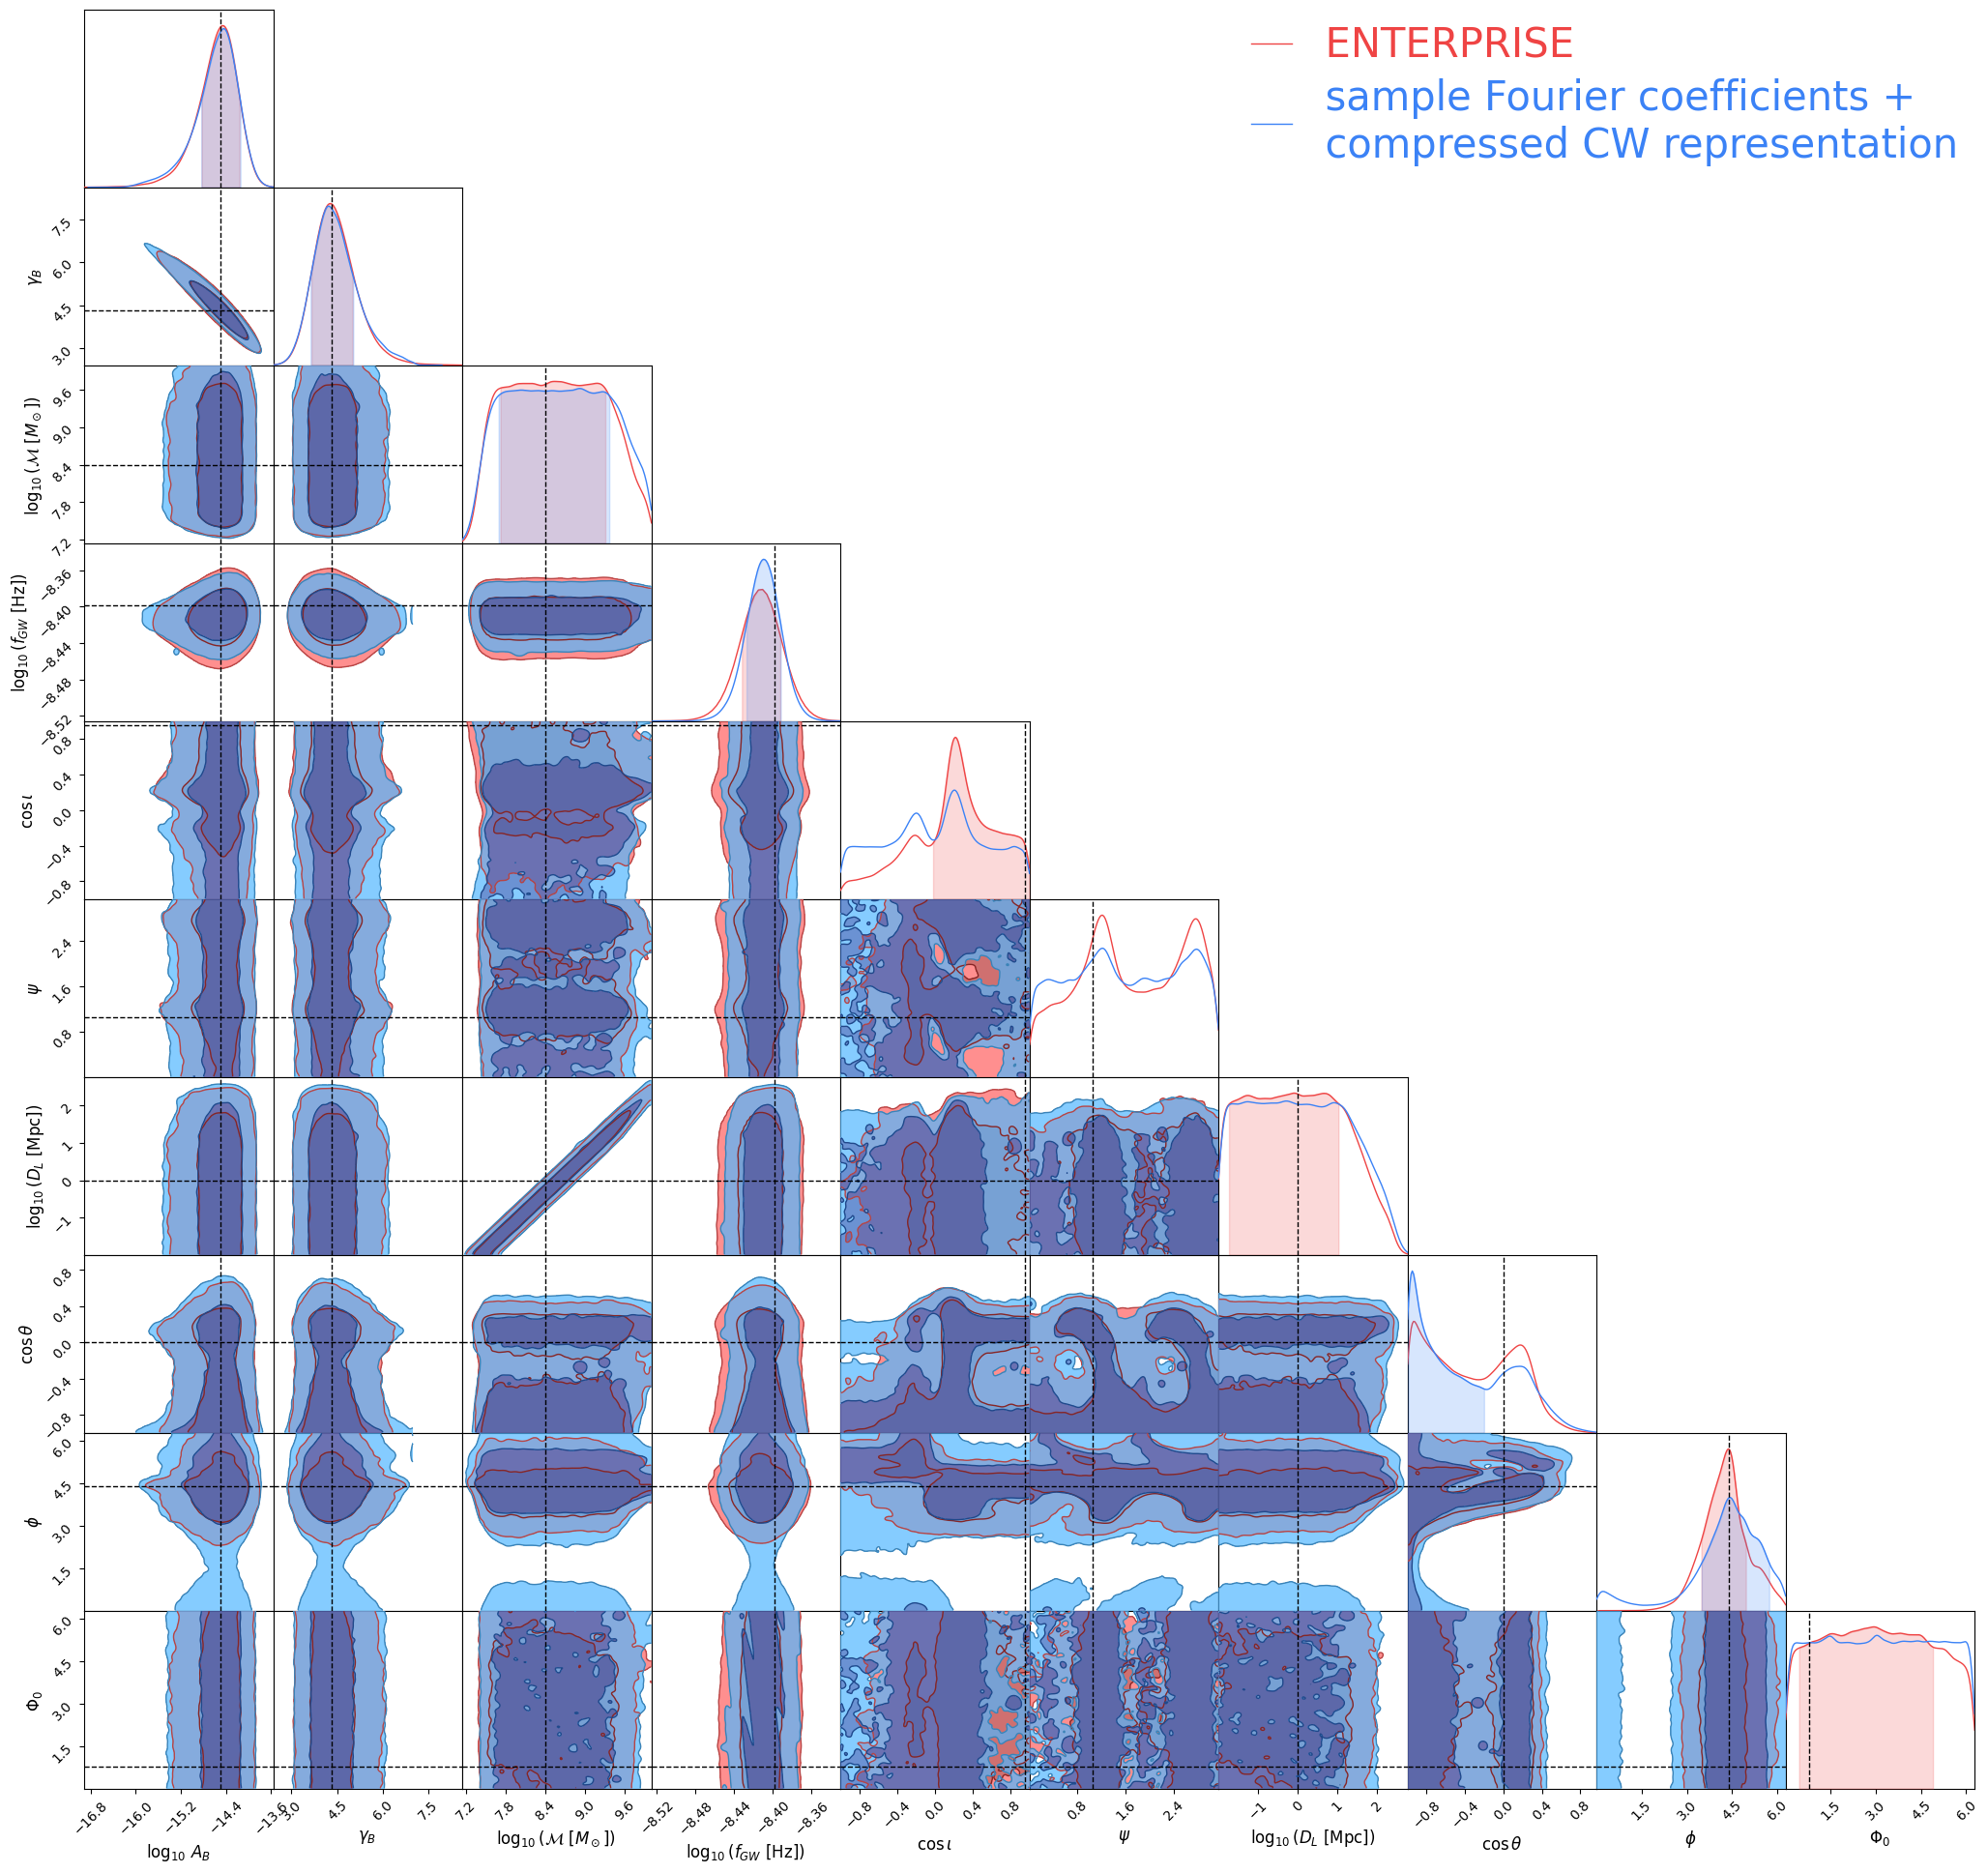

In [23]:
# corner plot
ndxs = np.r_[:10]
gwb_labels = np.array(['log10_A_gw', 'gamma_gw'])
cw_labels = np.array(['cw_log10_Mc', 'cw_log10_fgw', 'cw_cosinc', 'cw_psi',
                      'cw_log10_dL', 'cw_costheta', 'cw_phi', 'cw_phase0'])
phase_labels = np.array([f'{psr_name}_cw_p_phase' for psr_name in psr_names])
psr_dist_labels = np.array([f'{psr_name}_cw_p_dist' for psr_name in psr_names])
old_labels = np.concatenate((gwb_labels, cw_labels, phase_labels, psr_dist_labels))
new_labels = pta.x_labels[np.concatenate((pta.gwb_ndxs, pta.cw_ndxs, pta.psr_phase_ndxs, pta.psr_dist_ndxs))]
hmc_df = pd.DataFrame(hmc_samples.samples, columns=pta.x_labels)
ent_df.rename(columns={old: new for old, new in zip(old_labels, new_labels)}, inplace=True)

label_mapping = dict(zip(old_labels, new_labels))
x_inj_dict = {label_mapping.get(k, k): v for k, v in x_inj_dict.items()}

c = ChainConsumer()
c.add_chain(Chain(samples=ent_df[new_labels[ndxs]].iloc[::1], name='ENTERPRISE', color='red'))
c.add_chain(Chain(samples=hmc_df[new_labels[ndxs]], name='sample Fourier coefficients + \n  compressed CW representation', color='blue'))
c.add_truth(Truth(location=x_inj_dict))
c.set_plot_config(PlotConfig(legend_kwargs={'fontsize': 30}))
fig = c.plotter.plot()

In [27]:
hmc_ent_labels = hmc_df.rename(columns={new: old for old, new in zip(old_labels, new_labels)}, inplace=False)
hmc_ent_labels.to_pickle('hmc_ent_labels.pkl.gz', compression='gzip')

In [260]:
import arviz as az
pd.set_option('display.max_rows', None)

idata = az.from_dict(posterior={col: hmc_df[col].values[None, :] for col in hmc_df.columns})
ess = az.ess(idata, method='bulk')
ess_df = ess.to_array().to_dataframe('ess')
es_per_sec_df = ess_df / duration
es_per_sec_df.rename(columns={'ess': 'eff samples per sec'}, inplace=True)
display(es_per_sec_df)

,eff samples per sec
variable,
"$\log_{{{10}}}\,A_B$",0.948864
$\gamma_B$,0.869190
"$\log_{10}(\mathcal{M}\,\,[M_\odot])$",0.074192
"$\log_{10}(f_{GW}\,\,[\text{Hz}])$",0.214736
$\cos{\iota}$,0.690950
$\psi$,1.228580
"$\log_{10}(D_{L}\,\,[\text{Mpc}])$",0.082694
$\cos{\theta}$,0.794794
$\phi$,0.353273


In [261]:
ent_duration = 58971.680235
idata_ent = az.from_dict(posterior={col: ent_df[col].values[None, :] for col in ent_df.columns})
ess_ent = az.ess(idata_ent, method='bulk')
ess_ent_df = ess_ent.to_array().to_dataframe('ess')
es_per_sec_ent_df = ess_ent_df / ent_duration
es_per_sec_ent_df.rename(columns={'ess': 'eff samples per sec'}, inplace=True)
display(es_per_sec_ent_df)

,eff samples per sec
variable,
L [2],0.348079
$\Phi$ [2],0.006907
L [5],0.265921
$\Phi$ [5],0.090776
L [1],0.279388
$\Phi$ [1],0.069485
L [3],0.196473
$\Phi$ [3],0.014114
L [4],0.338910


In [306]:
ndxs = []
ratios = []
for ndx in es_per_sec_df.index:
    if ndx[:2] != '$a' and ndx[:2] != '$b':
        es_rate = es_per_sec_df.loc[ndx].values[0]
        es_ent_rate = es_per_sec_ent_df.loc[ndx].values[0]
        ratios.append(es_rate / es_ent_rate)
        ndxs.append(ndx)

ratios = np.array(ratios)
ndxs = np.array(ndxs)

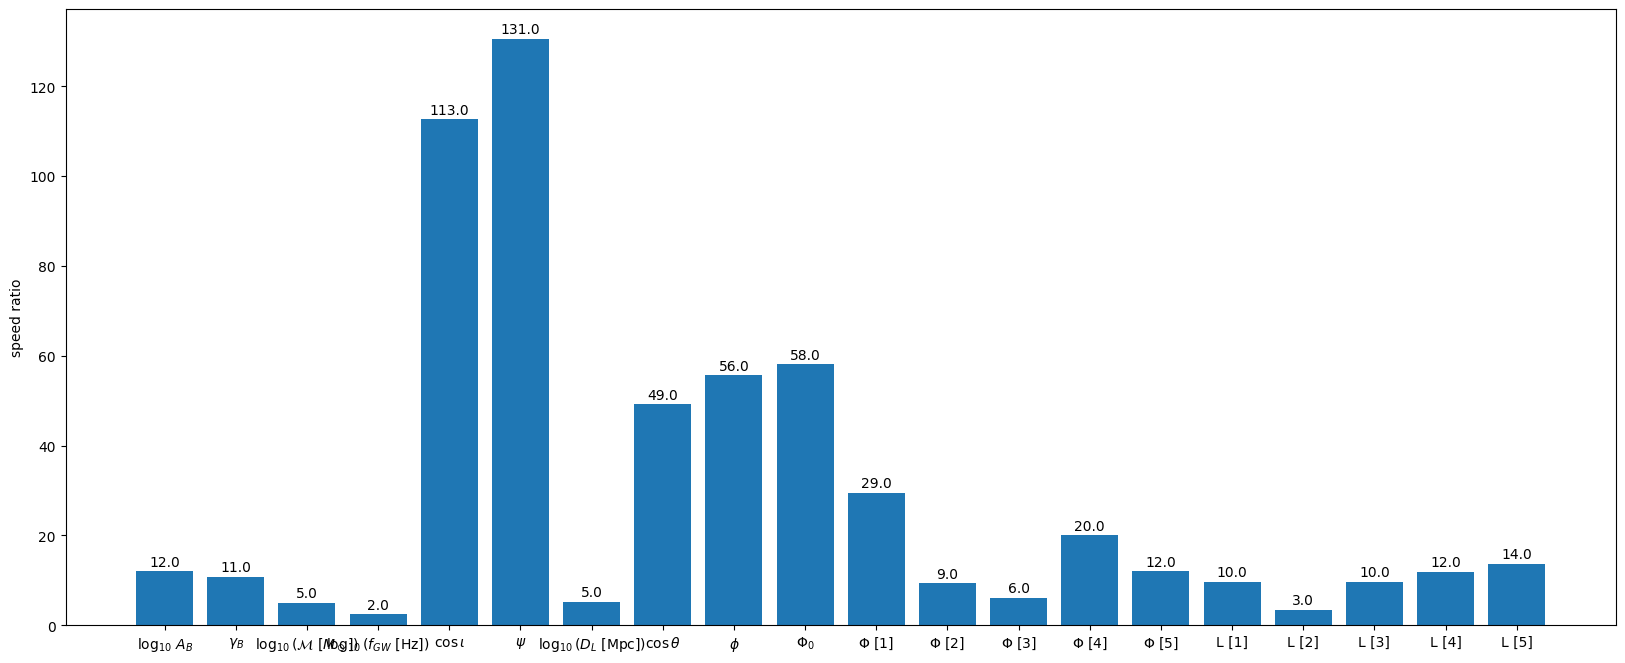

In [313]:
plt.figure(figsize=(20, 8))
plt.bar(ndxs, ratios)
for i, v in enumerate(ratios):
    plt.text(i, v + 0.5, str(np.round(v)), ha='center', va='bottom')
plt.ylabel('speed ratio')
plt.show()

In [288]:
min_param_eff_sample_rate = np.min(es_per_sec_df.to_numpy())
ent_min_param_eff_sample_rate = np.min(es_per_sec_ent_df.to_numpy())
speedup_ratio = min_param_eff_sample_rate / ent_min_param_eff_sample_rate
print(min_param_eff_sample_rate)
print(ent_min_param_eff_sample_rate)
print(speedup_ratio)

0.06496671656629914
0.006129644572753259
10.598773843279787


Parameter $\log_{10}(\mathcal{M}\,\,[M_\odot])$ in chain sample Fourier coefficients + 
  compressed CW representation is not constrained
Parameter $\cos{\iota}$ in chain sample Fourier coefficients + 
  compressed CW representation is not constrained
Parameter $\psi$ in chain ENTERPRISE is not constrained
Parameter $\psi$ in chain sample Fourier coefficients + 
  compressed CW representation is not constrained
Parameter $\log_{10}(D_{L}\,\,[\text{Mpc}])$ in chain sample Fourier coefficients + 
  compressed CW representation is not constrained
Parameter $\cos{\theta}$ in chain ENTERPRISE is not constrained
Parameter $\Phi_0$ in chain sample Fourier coefficients + 
  compressed CW representation is not constrained


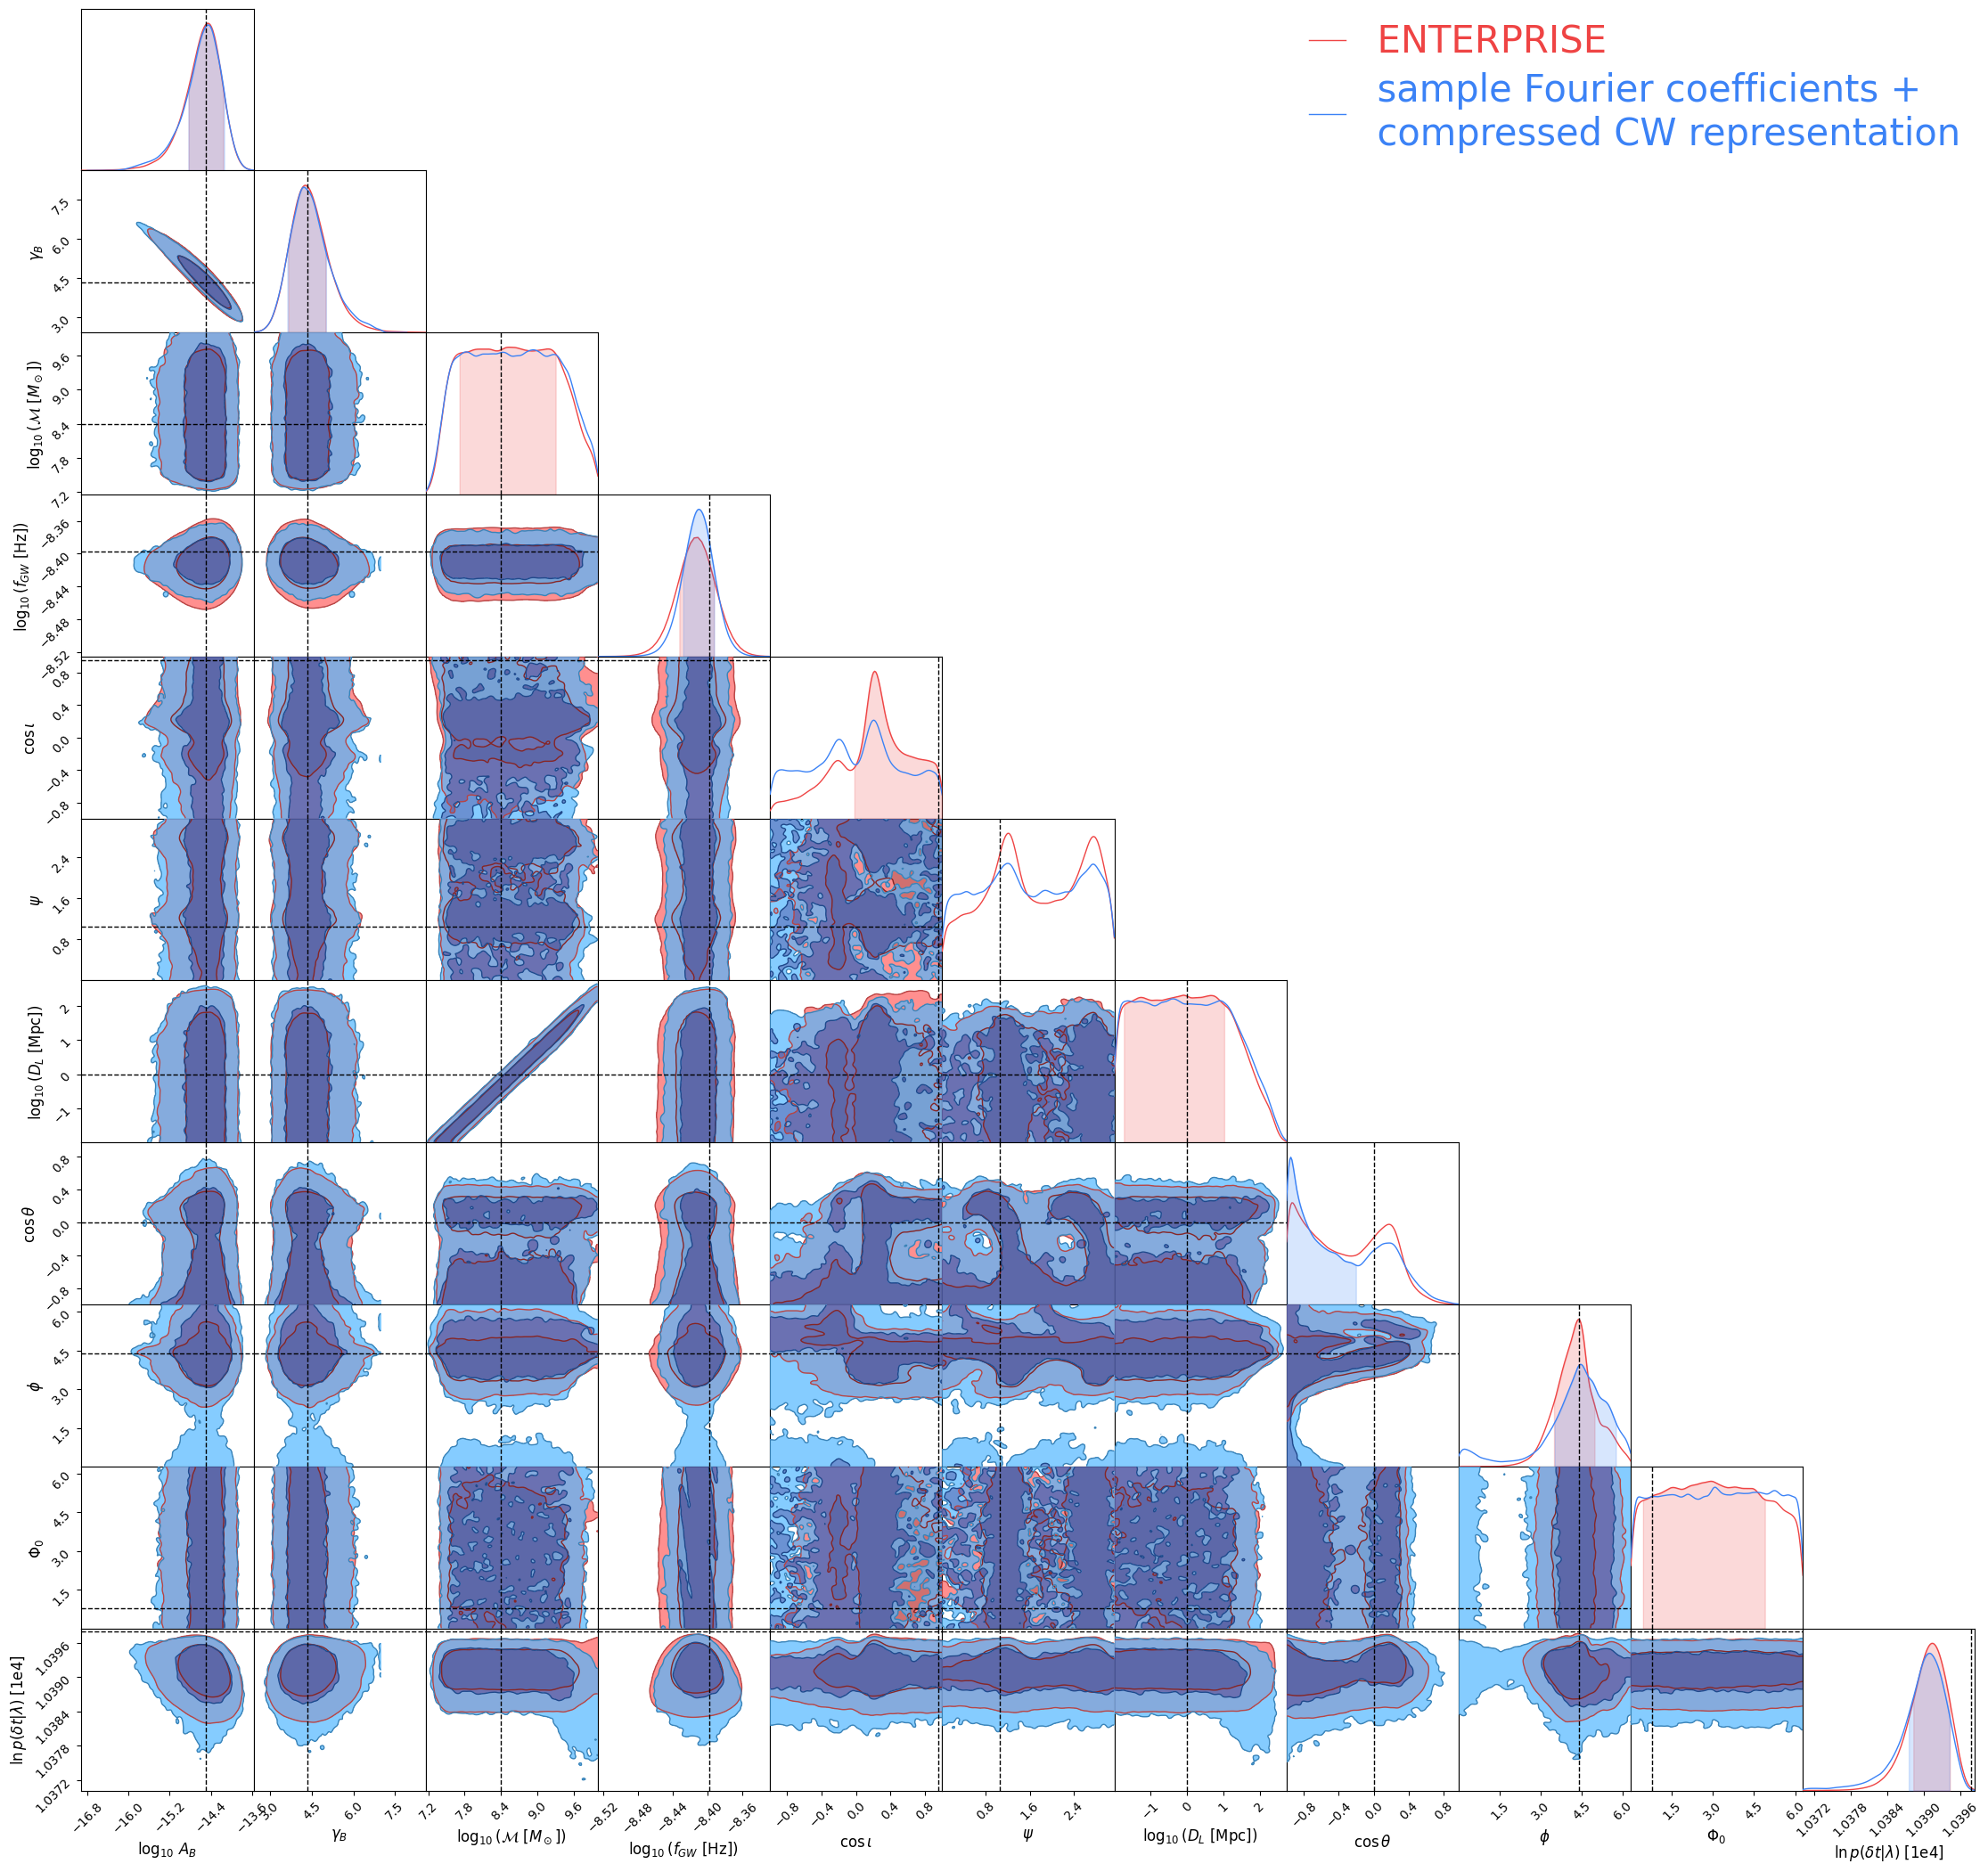

In [34]:
# corner plot
ndxs = np.r_[:10]

ent_df_with_lnlike = ent_df.copy()
lnlike_label = r'$\ln p(\delta t | \lambda)$'
ent_df_with_lnlike[lnlike_label] = np.load('ent_lnlikes.npy')[20_000:]
hmc_ent_labels_with_lnlike = pd.read_pickle('hmc_ent_labels.pkl.gz', compression='gzip')
hmc_with_lnlike = hmc_ent_labels_with_lnlike.rename(columns={old: new for old, new in zip(old_labels, new_labels)}, inplace=False)
hmc_with_lnlike.rename(columns={'lnlike': lnlike_label}, inplace=True)

c = ChainConsumer()
labels = np.concatenate((new_labels[ndxs], np.array([lnlike_label])))
c.add_chain(Chain(samples=ent_df_with_lnlike[labels].iloc[::1], name='ENTERPRISE', color='red'))
c.add_chain(Chain(samples=hmc_with_lnlike[labels], name='sample Fourier coefficients + \n  compressed CW representation', color='blue'))
x_inj_dict[lnlike_label] = np.max(hmc_with_lnlike[lnlike_label])
c.add_truth(Truth(location=x_inj_dict))
c.set_plot_config(PlotConfig(legend_kwargs={'fontsize': 30}))
fig = c.plotter.plot()